In [12]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv("profiles.csv")

# Remove age outlier
df = df[df.age < 90]

# Data Preparation

In [13]:
essay_columns = ["essay0","essay1","essay2","essay3","essay4","essay5","essay6","essay7","essay8","essay9"]
all_essays = df[essay_columns].replace(np.nan, '', regex=True)
df["essay_all"] = all_essays[essay_columns].apply(lambda x: " ".join(x), axis=1)
df["essays_sentiment"] = df.apply(lambda row: TextBlob(row["essay_all"]).sentiment.polarity, axis=1)

df["diet_code"] = df.diet.map({ "anything": 1, "strictly anything": 2, "mostly anything": 3, "other": 4, "mostly other": 5, "strictly other": 6, "vegan": 7, "mostly vegan": 8, "strictly vegan": 9, "vegetarian": 10, "mostly vegetarian": 11, "strictly vegetarian": 12, "halal": 13, "mostly halal": 14, "strictly halal": 15, "kosher": 16, "mostly kosher": 17, "strictly kosher": 18 })
df["drinks_code"] = df.drinks.map({ "not at all": 1, "rarely": 2, "often": 4, "socially": 3, "very often": 5, "desperately": 6 })
df["drugs_code"] = df.drugs.map({ "never": 0, "sometimes": 1, "often": 2 })
df["job_code"] = df.job.map({ "": 0, "artistic / musical / writer": 1, "banking / financial / real estate": 2, "clerical / administrative": 3, "computer / hardware / software": 4, "construction / craftsmanship": 5, "education / academia": 6, "entertainment / media": 7, "executive / management": 8, "hospitality / travel": 9, "law / legal services": 10, "medicine / health": 11, "military": 12, "other": 13, "political / government": 14, "rather not say": 15, "retired": 16, "sales / marketing / biz dev": 17, "science / tech / engineering": 18, "student": 19, "transportation": 20, "unemployed": 21 })
df["orientation_code"] = df.orientation.map({ "straight": 1, "gay": 2, "bisexual" : 3 })
df["sex_code"] = df.orientation.map({ "m": 1, "f": 2 })
df["smokes_code"] = df.smokes.map({ "no": 1, "sometimes": 2, "when drinking": 3, "trying to quit": 4, "yes": 5 })
df["status_code"] = df.status.map({ "unknown": 1, "married": 2, "seeing someone": 3, "single": 4, "available": 5 })
df["religion_type"] = df.religion.str.split().str.get(0)
df["religion_type"] = df.religion_type.replace(np.nan, 'not_specified', regex=True)
df["religion_code"] = df.religion_type.map({
    'not_specified': 0,
    'agnosticism': 1,
    'atheism': 2,
    'buddhism': 3,
    'catholicism': 4,
    'christianity': 5,
    'hinduism': 6,
    'islam': 7,
    'judaism': 8,
    'other': 9,
})

df.fillna({
    "diet_code": 0,
    "drinks_heavily": 0,
    "drinks_code": 0,
    "drugs_code": 0,    
    "job_code": 0,
    "orientation_code": 0,
    "sex_code": 0,
    "smokes_code": 0,
    "speaks": "",
    "status_code": 0,
    "religion_code": 0,
    "religion": "",
    "job": "",
    "essay0": "", "essay1": "", "essay2": "", "essay3": "", "essay4": "", 
    "essay5": "", "essay6": "", "essay7": "", "essay8": "", "essay9": ""}, inplace=True)

df["religion_strength"] = df.religion.str.split().apply(lambda x: " ".join(x[1:]) if type(x) == list else "")
df["religion_strength"] = df.religion_strength.map({ "": 0, "and laughing about it": 1, "but not too serious about it": 2, "and somewhat serious about it": 3, "and very serious about it": 4 })

df["religiosity"] = df.religion_type.map({
    'not_specified': 0,
    'agnosticism': -1,
    'atheism': -1,
    'buddhism': 1,
    'catholicism': 1,
    'christianity': 1,
    'hinduism': 1,
    'islam': 1,
    'judaism': 1,
    'other': 1,
})
df["religiosity"] = df.apply(lambda row: (row["religion_strength"] * row["religiosity"]), axis=1)

df["speaks_count"] = df.apply(lambda row: len(row.speaks.split(",")), axis=1)

# Initial Investigation

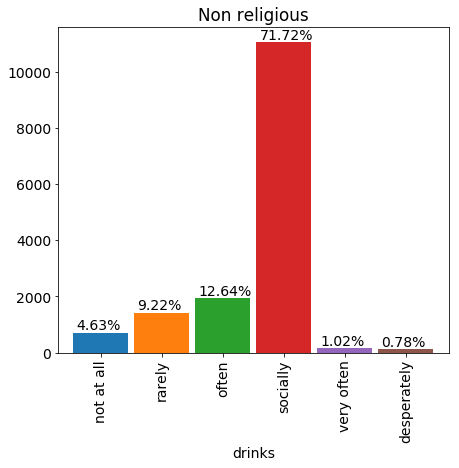

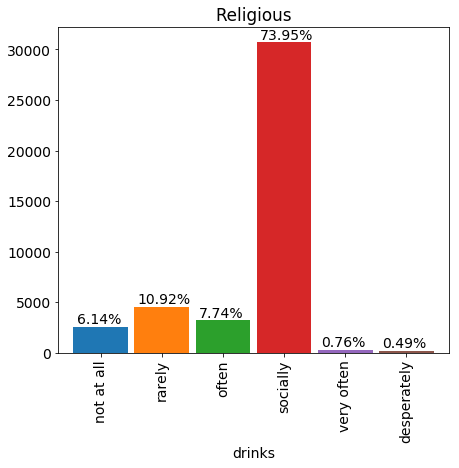

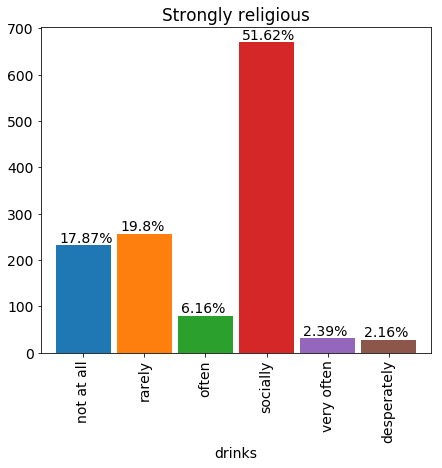

In [3]:
religion_classes = [ 'agnosticism', 'atheism', 'buddhism', 'catholicism', 'christianity', 'hinduism', 'islam', 'judaism', 'other' ]

data = df[df.religion.notnull()]
data = data[data.drinks.notnull()]

non_religious = data[data.religion.str.contains("agnosticism|atheism")]
religious = data[~data.religion.str.contains("agnosticism|atheism")]
strongly_religious = religious[religious.religion.str.contains("very serious")]

dataframes = [ non_religious, religious, strongly_religious ]
graph_titles = [ "Non religious", "Religious", "Strongly religious" ]
drinks_order = [ "not at all", "rarely", "often", "socially", "very often", "desperately" ]

plt.rcParams.update({'font.size': 14})
for i in range(0,3):
    total_items = len(dataframes[i])
    plt.figure(figsize=(7, 6))
    df_groupby = dataframes[i].groupby(["drinks"]).drinks.count()
    
    df_groupby = df_groupby.reindex(drinks_order)
    
    df_groupby.plot.bar(width=0.9)

    for j, v in enumerate(df_groupby):
        plt.text(j - 0.4, v + (max(df_groupby)/100), str(round(v/total_items*100,2)) + "%")
    
    plt.title(graph_titles[i])
    
    plt.show()


#  Classification

Scale data and create training and test datasets.

In [4]:
features = ["age", "drinks_code", "drugs_code", "orientation_code", "sex_code", "smokes_code", "status_code", "religion_code"]

points = df[features]
labels = df[["religion_strength"]]

scaler = MinMaxScaler()
points = scaler.fit_transform(points.values)
points = pd.DataFrame(points, columns=features)

training_data, validation_data, training_labels, validation_labels = train_test_split(points, labels, train_size = 0.8, test_size = 0.2, random_state = 100)


## K-Nearest Neighbor Classification

In [5]:
accuracy = []
precision = []
recall = []
classification_reports = []
confusion_matrices = []
k = 150

labs = validation_labels.values.reshape(1, len(validation_labels))[0]  

for i in range(1,k):
    classifier = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    classifier.fit(training_data, training_labels.values.ravel())
    prediction = classifier.predict(validation_data)
    
    accuracy.append(accuracy_score(labs, prediction))
    recall.append(recall_score(labs, prediction, average=None))
    precision.append(precision_score(labs, prediction, average=None))
    classification_reports.append(classification_report(labs, prediction))

C:\Users\kiera\Miniconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kiera\Miniconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Analyse accuracy, recall and precision

Best number of neighbors: 101
Max Accuracy: 0.5876219868212528
             precision    recall  f1-score   support

          0       0.68      0.85      0.75      6452
          1       0.34      0.21      0.26      1749
          2       0.43      0.48      0.45      2458
          3       0.00      0.00      0.00       876
          4       0.31      0.02      0.03       454

avg / total       0.51      0.59      0.54     11989



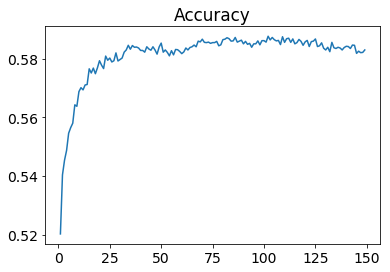

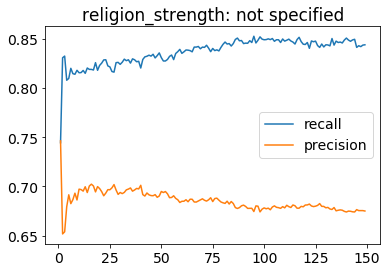

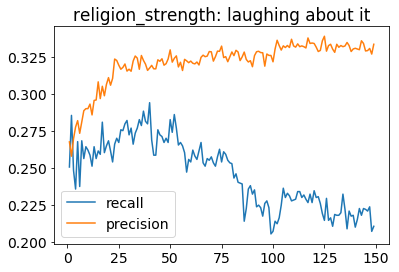

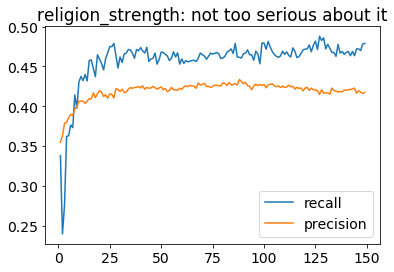

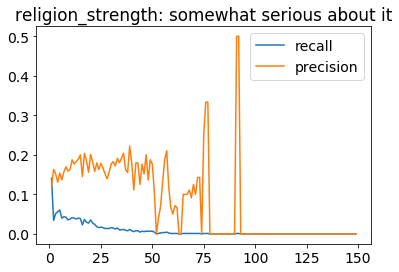

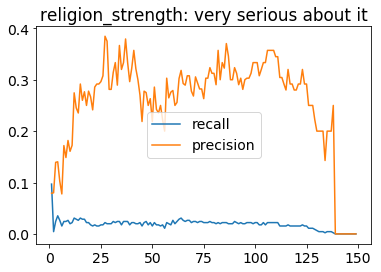

In [6]:
best_k = accuracy.index(max(accuracy))

print("Best number of neighbors: " + str(best_k))
print("Max Accuracy: " + str(max(accuracy)))

print(classification_reports[best_k])

plt.title("Accuracy")
plt.plot(range(1,k), accuracy)
plt.show()

class_names = [ "not specified", "laughing about it", "not too serious about it", "somewhat serious about it", "very serious about it"]
for i in range(0, len(class_names)):
    plt.plot(range(1,k), [x[i] for x in recall], label="recall")
    plt.plot(range(1,k), [x[i] for x in precision], label="precision")
    plt.title("religion_strength: %s" % (class_names[i]))
    plt.legend()
    plt.show()


## Support Vector Classification

In [7]:
import time

svm_accuracy = []
svm_precision = []
svm_recall = []
svm_classification_reports = []
svm_confusion_matrices = []

features = ["age", "drinks_code", "drugs_code", "orientation_code", "sex_code", "smokes_code", "status_code", "religion_code"]

points = df[features]
labels = df[["religion_strength"]]

scaler = MinMaxScaler()
points = scaler.fit_transform(points.values)
points = pd.DataFrame(points, columns=features)

training_data, validation_data, training_labels, validation_labels = train_test_split(points, labels, train_size = 0.8, test_size = 0.2, random_state = 100)

for C in [1, 10]:
    for gamma in [1, 10]:
        start_time = time.time()
        
        classifier = SVC(gamma=gamma,C=C)
        classifier.fit(training_data, training_labels.values.ravel())
        prediction = classifier.predict(validation_data)
        
        print("Time to execute (C=%s, gamma=%s): %s" % (C, gamma, (time.time() - start_time)))
        
        svm_accuracy.append(accuracy_score(validation_labels, prediction))
        svm_recall.append(recall_score(validation_labels, prediction, average=None))
        svm_precision.append(precision_score(validation_labels, prediction, average=None))
        svm_classification_reports.append(classification_report(validation_labels, prediction))
        svm_confusion_matrices.append(confusion_matrix(validation_labels, prediction))

Time to execute (C=1, gamma=1): 108.58242201805115
Time to execute (C=1, gamma=10): 136.52330803871155
Time to execute (C=10, gamma=1): 180.41487956047058
Time to execute (C=10, gamma=10): 312.5805859565735


Analyse the model

In [10]:
total_iterations = len(svm_accuracy) + 1

best_model = svm_accuracy.index(max(svm_accuracy))

print("Best model: " + str(best_model))
print("Max Accuracy: " + str(max(svm_accuracy)))

for i in range(0, len(svm_classification_reports)):
    print("Accuracy: " + str(svm_accuracy[i]))
    print(svm_classification_reports[i])

Best model: 2
Max Accuracy: 0.5875385770289432
Accuracy: 0.5847860538827259
             precision    recall  f1-score   support

          0       0.67      0.85      0.75      6452
          1       0.33      0.16      0.22      1749
          2       0.42      0.50      0.46      2458
          3       0.00      0.00      0.00       876
          4       0.00      0.00      0.00       454

avg / total       0.49      0.58      0.53     11989

Accuracy: 0.5859537909750605
             precision    recall  f1-score   support

          0       0.69      0.84      0.75      6452
          1       0.32      0.24      0.27      1749
          2       0.43      0.49      0.46      2458
          3       0.29      0.00      0.00       876
          4       0.50      0.00      0.01       454

avg / total       0.54      0.59      0.54     11989

Accuracy: 0.5875385770289432
             precision    recall  f1-score   support

          0       0.68      0.84      0.75      6452
          1

# Regression

Scale data and create training and test datasets.

In [15]:
features = [ "religiosity", "age", "drinks_code", "speaks_count" ]

X = df[features]
y = df[["essays_sentiment"]]

scaler = MinMaxScaler()
X = scaler.fit_transform(X.values)
X = pd.DataFrame(X, columns=features)

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=1)

## Linear Regression

Train score: 0.0319380559874195
Test score: 0.035876844882340664
Mean Absolute Error: 0.079863316036504
[('age', 0.08954449980787993), ('religiosity', 0.04820885327509072), ('speaks_count', -0.010212110333887617), ('drinks_code', -0.0011410391356666838)]


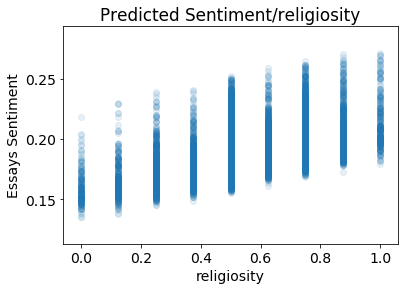

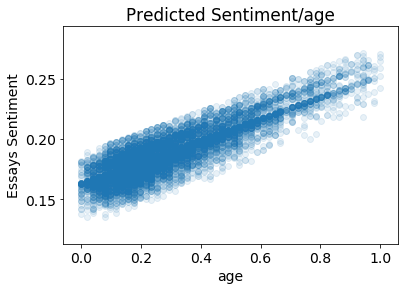

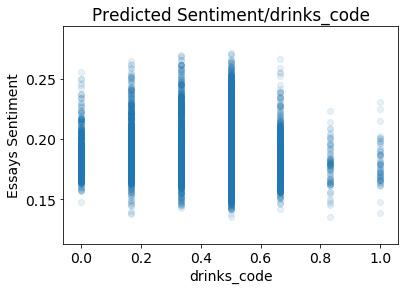

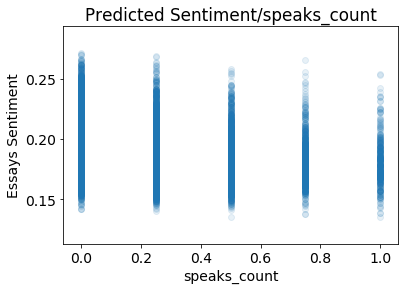

In [16]:
reg = LinearRegression()
reg.fit(x_train, y_train)

y_predict = reg.predict(x_test)

print("Train score: %s" % (reg.score(x_train, y_train)))
print("Test score: %s" % (reg.score(x_test, y_test)))
print("Mean Absolute Error: " + str(mean_absolute_error(y_test, y_predict)))
print(sorted(list(zip(features,reg.coef_[0])),key = lambda x: abs(x[1]),reverse=True))

for feature in features:
    plt.scatter(x_test[feature], y_predict, alpha=0.1)
    plt.title("Predicted Sentiment/%s" % (feature))
    plt.ylabel("Essays Sentiment")
    plt.xlabel(feature)
    plt.show()


## K-Nearest Neighbor Regression

Discover best number of neighbors

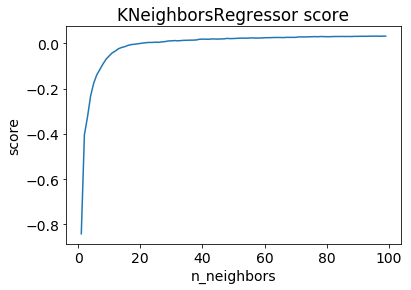

Best K: 98
Max Score: 0.03251729391190239


In [17]:
scores = []
k = 100

for i in range(1,k):
    neigh = KNeighborsRegressor(n_neighbors=i, n_jobs=-1)
    neigh.fit(x_train, y_train)
    scores.append(neigh.score(x_test, y_test))

plt.plot(range(1,k), scores)
plt.title("KNeighborsRegressor score")
plt.ylabel("score")
plt.xlabel("n_neighbors")
plt.show()

best_k = scores.index(max(scores))

print("Best K: " + str(best_k))
print("Max Score: " + str(max(scores)))

Analyse best model 

Train score: 0.047150790976623
Test score: 0.0322627439824229
Mean Absolute Error: 0.08000775917927044


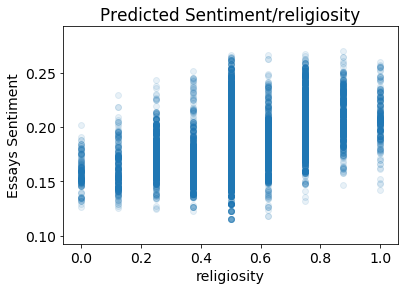

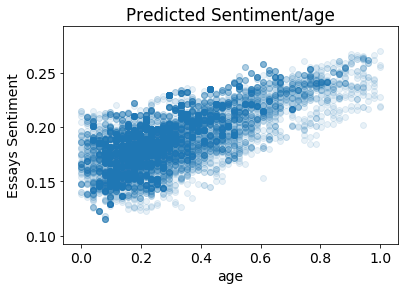

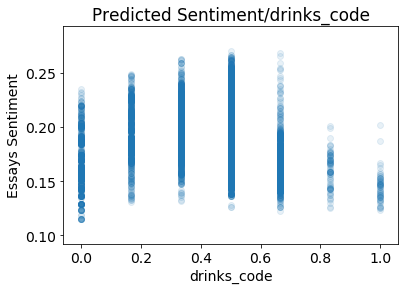

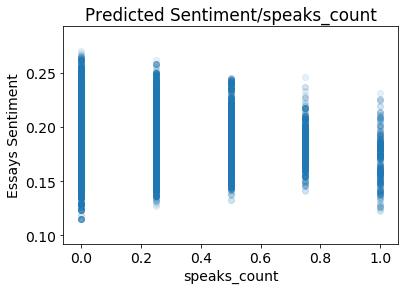

In [18]:
neigh = KNeighborsRegressor(n_neighbors=best_k, n_jobs=-1)
neigh.fit(x_train, y_train) 
y_predict = neigh.predict(x_test)

print("Train score: %s" % (neigh.score(x_train, y_train)))
print("Test score: %s" % (neigh.score(x_test, y_test)))
print("Mean Absolute Error: " + str(mean_absolute_error(y_test, y_predict)))

for feature in features:
    plt.scatter(x_test[feature], y_predict, alpha=0.1)
    plt.title("Predicted Sentiment/%s" % (feature))
    plt.ylabel("Essays Sentiment")
    plt.xlabel(feature)
    plt.show()